## Imports and global variables

In [37]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import csv

In [38]:
from implementations import *
from helpers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
DATA_FOLDER = "./data/"
TRAIN_FILE = "./train.csv"
TEST_FILE = "./test.csv"

NAN_VALUE = -999.0
INTEGER_COLUMN = (
    22  # 24 in raw csv file, but 23 when id and prediction column are removed
)

# For debug purpose only
SUB_SAMPLE = False

# Import dataset

In [40]:
# Load data
x_tr, y_tr = load_data(
    DATA_FOLDER + TRAIN_FILE, sub_sample=SUB_SAMPLE
)  # TODO use the provided method
x_te, y_te = load_data(DATA_FOLDER + TEST_FILE, sub_sample=SUB_SAMPLE)

print("x_tr shape : {}, y_tr shape : {}".format(x_tr.shape, y_tr.shape))
print("x_te shape : {}, y_te shape : {}".format(x_te.shape, y_te.shape))

# Define missing values as NAN
x_tr[x_tr == NAN_VALUE] = np.nan
x_te[x_te == NAN_VALUE] = np.nan

x_tr shape : (250000, 30), y_tr shape : (250000, 1)
x_te shape : (568238, 30), y_te shape : (568238, 1)


# Data exploration

## Labels

Signals: 85667 (34.2668%)
Backgrounds: 164333 (65.7332%)
Ratio signal / background: 0.521301260245964


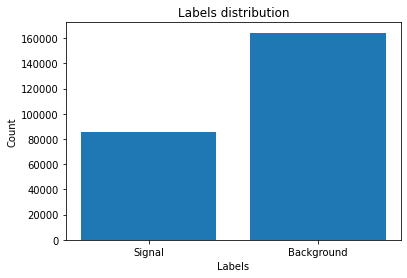

In [41]:
nb_s = len(y_tr[y_tr == 1])
nb_b = len(y_tr) - nb_s
print("Signals: {} ({}%)".format(nb_s, 100 * nb_s / len(x_tr)))
print("Backgrounds: {} ({}%)".format(nb_b, 100 * nb_b / len(x_tr)))
print("Ratio signal / background: {}".format(nb_s / nb_b))

plt.bar(["Signal", "Background"], [nb_s, nb_b])
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Labels distribution")
plt.show()

## Finding degree features and handling them

In [42]:
# IDs degrees columns
IDs_degrees = np.array([17, 20, 22, 27, 30])
# Find degree features and expand them
x_tr = expand_degrees(x_tr, IDs_degrees)
x_te = expand_degrees(x_te, IDs_degrees)

## NAN values

In [43]:
MAX_NAN_RATIO = 0.5

nb_nan = np.count_nonzero(np.isnan(x_tr), axis=0)
nan_ratio = nb_nan / x_tr.shape[1]


print(
    "Nb Columns with > {:.2f} nan ratio : {}".format(
        MAX_NAN_RATIO, np.count_nonzero(nan_ratio >= MAX_NAN_RATIO)
    )
)

col_names = []
with open(DATA_FOLDER + TRAIN_FILE) as dataset:
    col_names = dataset.readline().split(",")
    nan_col_names = [
        col_name for col_idx, col_name in enumerate(col_names[2:]) if nan_ratio[col_idx]
    ]

    print("Columns with > {:.2f} nan ratio :".format(MAX_NAN_RATIO))
    print(nan_col_names)

Nb Columns with > 0.50 nan ratio : 12
Columns with > 0.50 nan ratio :
['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi']


## Histograms

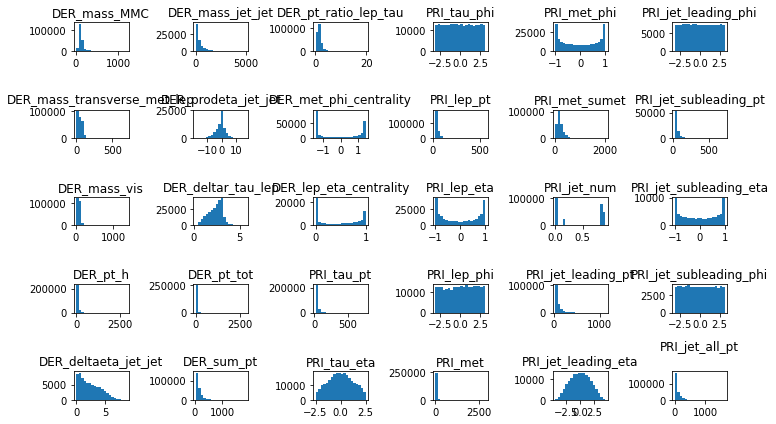

In [44]:
fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(10, 6))

# don't select nan values
for col_idx in range(len(col_names) - 2):
    subplt = axs[col_idx % 5, math.floor(col_idx / 5)]

    col = x_tr[:, col_idx]
    subplt.hist(col[~np.isnan(col)], bins=20)
    subplt.set_title(col_names[col_idx + 2])

plt.tight_layout()

# fig.title("Histograms of raw features (exclude NAN values)")
plt.show()

## In depth feature analysis

In [45]:
col_names[6]

'DER_deltaeta_jet_jet'

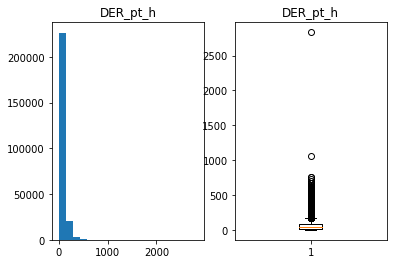

In [46]:
# Plot a feature
col_name_to_plot = "DER_pt_h"
# col_names
col_idx_to_plot = [
    col_idx - 2
    for col_idx, col_name in enumerate(col_names)
    if col_name_to_plot == col_name
]

col_to_plot = x_tr[:, col_idx_to_plot]

fig, axs = plt.subplots(1, 2)
axs[0].hist(col_to_plot[~np.isnan(col_to_plot)], bins=20)
axs[0].set_title(col_name_to_plot)

col_nan = col_to_plot[~np.isnan(col_to_plot)]
axs[1].boxplot(col_to_plot[~np.isnan(col_to_plot)])
axs[1].set_title(col_name_to_plot)

plt.show()

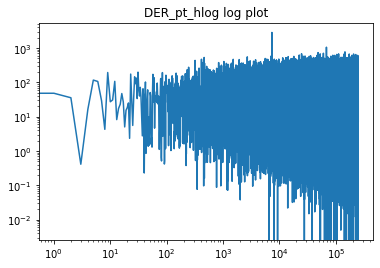

In [47]:
plt.loglog(col_to_plot[~np.isnan(col_to_plot)])
plt.title(col_name_to_plot + "log log plot")
plt.show()

In [48]:
# heatmap
# np.corrcoef(col_to_plot)

# Feature engineering / Data cleaning

Basic transformations
- Remove features which contains too much NAN values, because they don't contain ennough information
- Standardize training df
- Replace missing values

In [49]:
# Remove columns with too much NAN
x_tr = x_tr[:, nan_ratio <= MAX_NAN_RATIO]
x_te = x_te[:, nan_ratio <= MAX_NAN_RATIO]

print("x_tr shape : {}".format(x_tr.shape))
print("x_te shape : {}".format(x_te.shape))

# Standardize before replacing missing values
x_tr, mean_x, std_x = standardize_training(x_tr, missing_values=True)
x_te = standardize_test(x_te, mean_x, std_x)

# Replace missing data by the mean
x_tr = replace_nan_by_means(x_tr, mean_data=mean_x)
x_te = replace_nan_by_means(x_te, mean_data=mean_x)

assert x_tr[np.isnan(x_tr)].shape[0] == 0
assert x_te[np.isnan(x_te)].shape[0] == 0

# TODO : look at that
print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))

x_tr shape : (250000, 23)
x_te shape : (568238, 23)
x_tr range :-2.7654533479598604 126.4322216845244
x_te range :-2.7284120321456804 36.86455391749545


## Model fitting

In [50]:
# Add offset term to x
xt_tr = add_offset(x_tr)
xt_te = add_offset(x_te)

# Fit a model
w, loss_tr = least_squares(y_tr, x_tr)

print("Training loss : {}".format(loss_tr))

Training loss : 0.14550752651641902


# Model fitting and Predictions

In [51]:
# w_init = np.zeros((xt_tr.shape[1], 1))
# logistic_regression_penalized_gradient_descent_demo(y_tr, xt_tr, w_init, 10000, 0.0005, 0.5)

## Cross-validation

In [95]:
from implementations import *
from helpers import *

w_init, _ = least_squares(y_tr, xt_tr)
mean_loss_tr, mean_loss_te = run_cross_validation(y_tr, xt_tr, 2, w_init, 5, 1e-6)
print("Mean training mse: {}".format(mean_loss_tr))
print("Mean test mse: {}".format(mean_loss_te))

# 2000 1e-06 = 0.715393
# 4000 1e-06 = 0.714568
# 2222 35e-05 = 0.69306
# 888.88 35e-05 = 0.69303
# 444.44 35e-05 = 0.69234
# 222.22 35e-05 = 0.69235
# 111    36e-05 = 0.69170

i
3000, 3e-07
3000, 3e-07
i
3000, 3e-07
3000, 3e-07
Mean training mse: 0.7156677773508711
Mean test mse: 0.7156688574459458


## Predictions

### Predictions with regression and threshold

In [53]:
# # Make predictions from model's weight and set treshold for signal & background
# y_predict = x_te@w
# prediction_threshold = y_te.mean()

In [54]:
# prediction_threshold = 0
# print(y_predict.shape)
# for i in range(len(y_predict)) :
#     if y_predict[i] <= prediction_threshold :
#         y_predict[i] = 1
#     else :
#         y_predict[i] = -1
# print(y_predict.shape)
# y_test, input_test, ids_test = load_csv_data('./data/test.csv',False)
# create_csv_submission(ids_test,y_predict,"prediction test least square + feature engineering")

### Predictions with log_reg

In [80]:
# logistic_regression(y, tx, initial_w, max_iters, gamma)
# Fit the model
w_init, _ = least_squares(y_tr, xt_tr)
w, loss = reg_logistic_regression(y_tr, xt_tr, 4444, w_init, 1000, 35e-5)

In [81]:
y_predict = sigmoid(xt_te @ w)

In [82]:
prediction_threshold = 0.5
for i in range(len(y_predict)):
    if y_predict[i] >= prediction_threshold:
        y_predict[i] = 1
    else:
        y_predict[i] = -1

print(len(y_predict[y_predict == 1]))
print(len(y_predict[y_predict == -1]))
print(len(y_predict))

217648
350590
568238


In [83]:
y_test, input_test, ids_test = load_csv_data("./data/test.csv", False)
create_csv_submission(
    ids_test, y_predict, "prediction test least square + feature engineering"
)